## Brain tumor segmentation model

In [1]:

!pip install tensorflow
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import keras-cv for focal loss

!pip install keras-cv
import keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 47.7 MB/s eta 0:00:00


In [2]:
# Initialize random seed for reproducibility

import random, numpy as np, tensorflow as tf
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

### Initial set-up for utilizing Colab TPU

In [3]:
# Set memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Then initialize strategy
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")


Number of devices: 1


### Data Preparation

#### Loading the data from kaggle

In [4]:
# Uploading the kaggle api key from the system

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saumya12345","key":"b62855291cca7b61b5f1b1672ed1c8bd"}'}

In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Downloading the dataset from kaggle

!kaggle datasets download -d nikhilroxtomar/brain-tumor-segmentation


Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation
License(s): unknown
 77% 240M/312M [00:00<00:00, 754MB/s] 
100% 312M/312M [00:00<00:00, 812MB/s]


In [7]:
import zipfile

with zipfile.ZipFile('brain-tumor-segmentation.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')


#### Converting to numpy array and normalization

In [8]:
# Define paths to image and mask directories
image_dir = "dataset/images"
mask_dir = "dataset/masks"

# List all the PNG files in both directories in sorted order
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))


target_size = (256, 256)

images = []
masks = []

# Load images and masks into numpy arrays
for img_file, mask_file in zip(image_files, mask_files):
    img_path = os.path.join(image_dir, img_file)
    mask_path = os.path.join(mask_dir, mask_file)

    # Open the image and mask and convert to grayscale; resize to target size
    img = Image.open(img_path).convert("L").resize(target_size)  # Default -> bilinear

    # Resize tumor segmentation masks using nearest-neighbor interpolation.
    # This preserves the discrete 0/1 label values without introducing gray pixels
    # at the boundaries (which happens with bilinear interpolation).
    # Nearest-neighbor is the standard practice for resizing binary masks in medical image segmentation.

    mask = Image.open(mask_path).convert("L").resize(target_size, Image.NEAREST)  # Uses nearest neighbor


    # Convert to numpy arrays
    img_array = np.array(img)
    mask_array = np.array(mask)

    # Normalize the images and masks
    img_array = img_array / 255.0
    mask_array = mask_array / 255.0

    # Append to lists
    images.append(img_array)
    masks.append(mask_array)

# Convert the lists to numpy arrays
images = np.array(images)
masks = np.array(masks)

# Print the shapes of the arrays
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

Images shape: (3064, 256, 256)
Masks shape: (3064, 256, 256)


In [9]:
def check_masks(masks):
  # Checks if all elements in the masks list are either 0 or 1.
  for mask in masks:
    if not np.isin(mask, [0, 1]).all():
      return False
  return True

# Check your masks list
all_0_or_1 = check_masks(masks)

if all_0_or_1:
  print("All mask elements are either 0 or 1")
else:
  print("Some mask elements are not 0 or 1")

All mask elements are either 0 or 1


#### Display a few examples

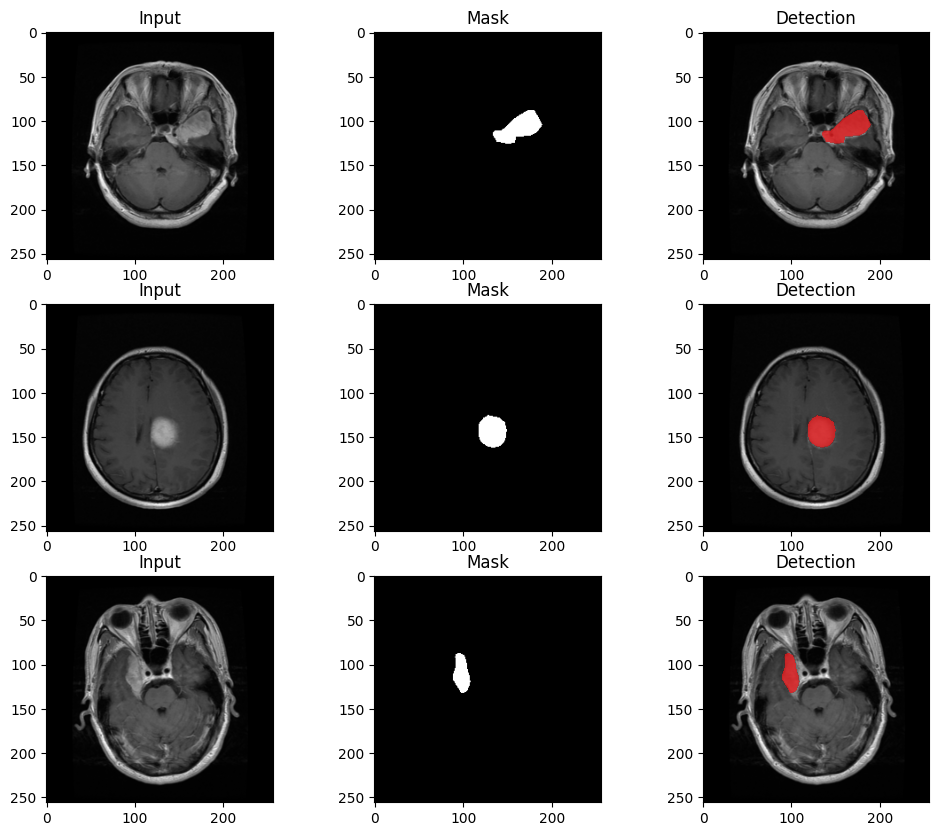

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

plt.subplot(3,3,1)
plt.title('Input')
plt.imshow(images[0,:], cmap = 'gray')

plt.subplot(3,3,2)
plt.title('Mask')
plt.imshow(masks[0,:], cmap = 'gray')

plt.subplot(3,3,3)
plt.title('Detection')
plt.imshow(images[0,:],cmap='gray')
mask = np.ma.masked_where(masks[0] == False, masks[0])
plt.imshow(mask, alpha=0.8, cmap='Set1')

plt.subplot(3,3,4)
plt.title('Input')
plt.imshow(images[1,:], cmap = 'gray')

plt.subplot(3,3,5)
plt.title('Mask')
plt.imshow(masks[1,:], cmap = 'gray')

plt.subplot(3,3,6)
plt.title('Detection')
plt.imshow(images[1,:],cmap='gray')
mask = np.ma.masked_where(masks[1] == False, masks[1])
plt.imshow(mask, alpha=0.8, cmap='Set1')

plt.subplot(3,3,7)
plt.title('Input')
plt.imshow(images[2,:], cmap = 'gray')

plt.subplot(3,3,8)
plt.title('Mask')
plt.imshow(masks[2,:], cmap = 'gray')

plt.subplot(3,3,9)
plt.title('Detection')
plt.imshow(images[2,:],cmap='gray')
mask = np.ma.masked_where(masks[2] == False, masks[2])
plt.imshow(mask, alpha=0.8, cmap='Set1')

#### Split into train, test and validation sets

In [11]:
from sklearn.model_selection import train_test_split

# Define the split ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Initialize lists to store the split data
train_images, train_masks = [], []
val_images, val_masks = [], []
test_images, test_masks = [], []



# Split into train, validation, and test for the current batch

# 1. Split into train and test set
X_temp, X_test, mask_temp, mask_test = train_test_split(
        images, masks, test_size=test_ratio, random_state=42
    )

# 2. Split the test set into test and validation set
X_train, X_val, mask_train, mask_val = train_test_split(
        X_temp, mask_temp, test_size=val_ratio / (train_ratio + val_ratio), random_state=42
    )





In [12]:
# delete earlier lists to free up some memory

del images
del masks

In [13]:
del image_files
del mask_files

In [14]:
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 1838
Validation set size: 613
Test set size: 613


#### Resizing the data so that channel information is also captured

In [15]:
# Resizing the data so that channel information is also captured
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

mask_train = mask_train.reshape(mask_train.shape[0], mask_train.shape[1], mask_train.shape[2], 1)
mask_test = mask_test.reshape(mask_test.shape[0], mask_test.shape[1], mask_test.shape[2], 1)

X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
mask_val = mask_val.reshape(mask_val.shape[0], mask_val.shape[1], mask_val.shape[2], 1)


# Verifying the shapes
print(X_train.shape)
print(mask_train.shape)
print('\n')
print(X_test.shape)
print(mask_test.shape)
print('\n')
print(X_val.shape)
print(mask_val.shape)



(1838, 256, 256, 1)
(1838, 256, 256, 1)


(613, 256, 256, 1)
(613, 256, 256, 1)


(613, 256, 256, 1)
(613, 256, 256, 1)


#### Save test data to disk

In [16]:
import numpy as np

np.savez_compressed("test_data.npz", X=X_test, y=mask_test)
